Import all necessary packages, check cuda

In [1]:
import torch
from torch.utils.data import DataLoader

from GPUtil import showUtilization as gpu_usage
from numba import cuda

import os
import tqdm
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import librosa
import librosa.display
from AutoEncoderClass import *

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Get user path to data, create train, validation and test datasets

In [2]:
def train_val_test(dataset_path = None, cases = []):
    data_csv = pd.read_csv(dataset_path)
    
    data_pd = pd.DataFrame()
    for case_number in cases: 
        data_pd = pd.concat([data_pd, data_csv[(data_csv["Case"] == "case"+str(case_number))] ])
    
    #train data only needs normal data, validation and test data need normal and abnormal data
    data_normal = data_pd[(data_pd["norm/ab"] == "normal")]
    data_abnormal = data_pd[(data_pd["norm/ab"] == "abnormal")]
        
    train_dataset, interm_dataset  = train_test_split(data_normal, test_size=0.2, shuffle = True)
    data_abnormal = pd.concat([data_abnormal, interm_dataset])
    validation_dataset, test_dataset= train_test_split(data_abnormal, test_size=0.8, shuffle= True) #only small validation

    return shuffle(train_dataset), shuffle(validation_dataset), shuffle(test_dataset)

    
datapath = r'C:\Users\brech\THESIS_local\ToyADMOS\ToycarCSV.csv'
train_dataset, validation_dataset, test_dataset = train_val_test(dataset_path = datapath, cases=[1])

datasets are of the form: Full Sample Name, Toytype,  Case,	norm/ab, IND/CNT, Channel, sample_ID

In [3]:
#helper functions 
def find_path_to_wav(full_sample_name):
    for root, dirs, files in os.walk(os.path.dirname(datapath)):
        for name in files:
            if name == full_sample_name:
                path_to_wavFile = os.path.abspath(os.path.join(root, name))
                return path_to_wavFile


def get_sample_waveform_normalised(full_sample_name, start = 0, stop = 11):
    #returns waveform values, cut to seconds going from start to stop
    sample_path = find_path_to_wav(full_sample_name)
    waveform, sample_rate = librosa.load(sample_path, sr= None)
    waveform = waveform[start*sample_rate : stop*sample_rate]
        
    return librosa.util.normalize(waveform)

In [4]:
X_train_wav = train_dataset["Full Sample Name"].values
X_test_wav = test_dataset["Full Sample Name"].values
X_valid_wav = validation_dataset["Full Sample Name"].values

batch_train = np.array([get_sample_waveform_normalised(elem,4,5) for elem in X_train_wav])
batch_test = np.array([get_sample_waveform_normalised(elem,4,5) for elem in X_test_wav])
batch_val = np.array([get_sample_waveform_normalised(elem,4,5) for elem in X_valid_wav])

X_train = DataLoader(batch_train, batch_size = 32, shuffle = False)
X_test = DataLoader(batch_test, batch_size = 32, shuffle = False)
X_val = DataLoader(batch_val, batch_size = 32, shuffle = False)

for example, batch_test is (1709,16000)
with batch size of 32, this gives 53.4 (so 54) arrays, each with 32 samples 

so 1 batch: 32 samples, size (32, 16000)
==> 54 batches

idea is to feed batch per batch to the neural net


for batch_train (4320,16000) this would give 135 batches (each with 32 samples)

Set autoencoder parameters

In [5]:
model = AutoEncoder(16000).to(device=device) #assume 1 sec of waveform
model_loss = nn.MSELoss()    #nn.L1Loss()? best type of loss for sound?
learning_rate = 0.01
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=16000, out_features=1000, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): Tanh()
    (4): Linear(in_features=500, out_features=250, bias=True)
    (5): Tanh()
    (6): Linear(in_features=250, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=250, bias=True)
    (3): Tanh()
    (4): Linear(in_features=250, out_features=500, bias=True)
    (5): Tanh()
    (6): Linear(in_features=500, out_features=1000, bias=True)
    (7): Tanh()
    (8): Linear(in_features=1000, out_features=16000, bias=True)
  )
)


In [6]:
epochs = 4
original_waves = []
reconstructed_waves = []
losses = []
    
def train(epochs, model, model_loss):
    for epoch in tqdm.tqdm(range(epochs)):
        
        for batch_idx, data in enumerate(X_train):
            
            # Zero your gradients for every batch!
            optimizer.zero_grad()
    
            # Make predictions for this batch
            outputs = model(data.to(device= device))
    
            # Compute the loss and its gradients
            loss = model_loss(outputs, data.to(device= device))
            loss.backward()
    
            # Adjust learning weights
            optimizer.step()
           
            losses.append(loss)
            
            #del original #free memory

        
        #hier validation data gebruiken

train(model=model, epochs=epochs, model_loss=model_loss)


100%|██████████| 3/3 [00:17<00:00,  6.00s/it]


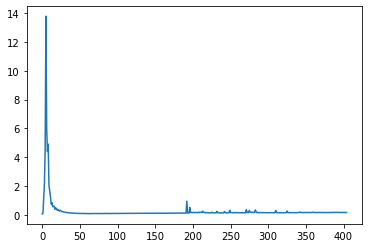

In [8]:
plt.plot([X.detach().cpu().numpy().item() for X in losses])
plt.show()